In [79]:
import pandas as pd
import numpy as np
import re
import nltk
import gensim.downloader as api
from tqdm import tqdm
from nltk.corpus import wordnet
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import nlpaug.augmenter.word as naw
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def load_data(file_path):
    return pd.read_csv(file_path, sep='\t')

data = load_data('2018-E-c-En-train.txt')
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

data['Tweet'] = data['Tweet'].apply(preprocess_text)
full_train_data, full_test_data = train_test_split(data, test_size=0.2, random_state=42)

In [80]:
synonym_aug = naw.SynonymAug(aug_src='wordnet')
insert_aug = naw.RandomWordAug(action="insert")
swap_aug = naw.RandomWordAug(action="swap")

target_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

class_counts = full_train_data[target_columns].sum().to_dict()

def augment_minority_class(df, target_column, num_augments=5, augment_type='synonym'):
    minority_df = df[df[target_column] == 1]
    augmented_texts = []
    
    for _, row in minority_df.iterrows():
        for _ in range(num_augments):
            augmented_text = synonym_aug.augment(row['Tweet'])
            new_row = row.copy()
            new_row['Tweet'] = augmented_text[0]
            augmented_texts.append(new_row)
    
    return pd.DataFrame(augmented_texts)

In [81]:
augmented_dfs = []
threshold = 250

for target_column in target_columns:
    if class_counts[target_column] < threshold:
        augmented_df = augment_minority_class(full_train_data, target_column, num_augments=5, augment_type='synonym')
        augmented_dfs.append(augmented_df)

full_train_data = pd.concat([full_train_data] + augmented_dfs, ignore_index=True)

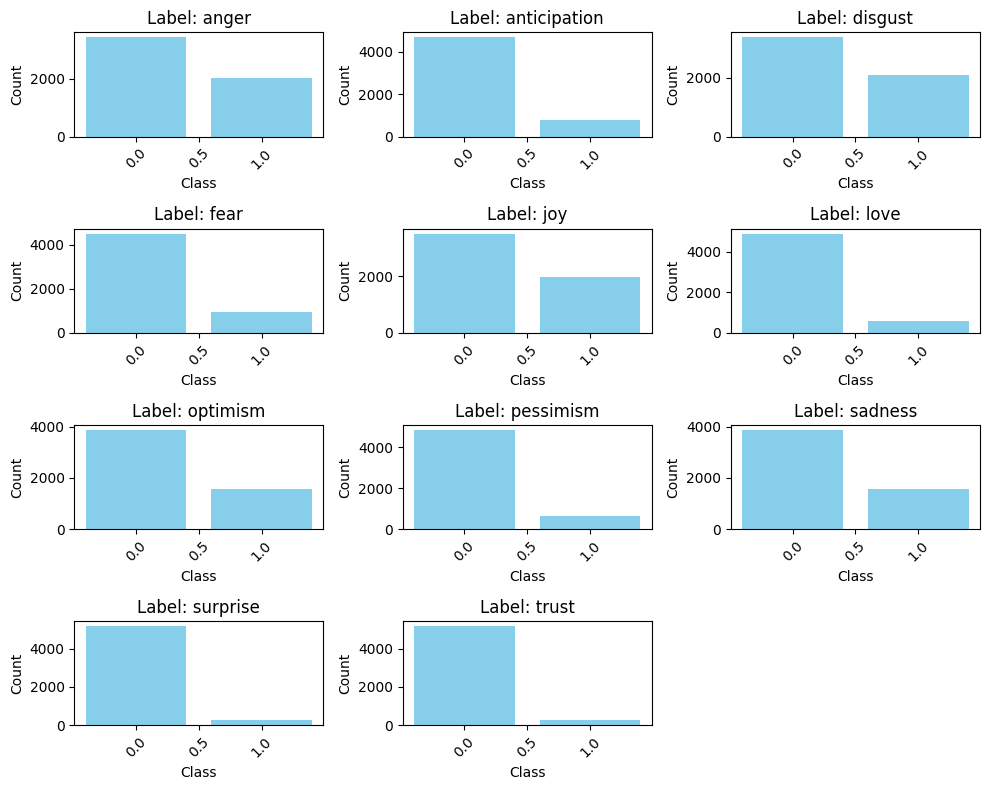

In [82]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 8))
axes = axes.flatten()

for i, target_column in enumerate(target_columns):
    class_counts = full_train_data[target_column].value_counts()
    
    axes[i].bar(class_counts.index, class_counts.values, color='skyblue')
    
    axes[i].set_title(f'Label: {target_column}')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Count')
    
    plt.setp(axes[i].get_xticklabels(), rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Исходные данные загружаются, очищаются от символов, кроме букв и пробелов, приводятся к нижнему регистру, а затем разделяются на обучающую и тестовую выборки. Для обеспечения баланса классов используется аугментация. Графики показывают распределение значений 0/1 для каждого из 11 классов эмоций ('anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'). После аугментации каждый класс представлен минимум 250 раз.

In [83]:
train_labels = full_train_data[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']]
train_data = full_train_data['Tweet']

test_labels = full_test_data[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']]
test_data = full_test_data['Tweet']

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

result_metrics = {}

### Create Embedings

In [97]:
def one_hot_encode_words(train_data, test_data):
    all_words = [word for tweet in train_data['Tweet'] for word in tweet.split()]
    all_words += [word for tweet in test_data['Tweet'] for word in tweet.split()]

    unique_words = list(set(all_words))
    encoder = OneHotEncoder(sparse_output=False)
    encoder.fit(np.array(unique_words).reshape(-1, 1))
    
    one_hot_vectors_train = []
    for tweet in tqdm(train_data['Tweet']):
        tweet_words = tweet.split()
        one_hot_vector = np.sum(encoder.transform(np.array(tweet_words).reshape(-1, 1)), axis=0)
        one_hot_vectors_train.append(one_hot_vector)
    
    one_hot_vectors_test = []
    for tweet in tqdm(test_data['Tweet']):
        tweet_words = tweet.split()
        one_hot_vector = np.sum(encoder.transform(np.array(tweet_words).reshape(-1, 1)), axis=0)
        one_hot_vectors_test.append(one_hot_vector)
    
    return np.array(one_hot_vectors_train), np.array(one_hot_vectors_test), unique_words

one_hot_encoded_train, one_hot_encoded_test, unique_words = one_hot_encode_words(train_data, test_data)
one_hot_encoded_train = one_hot_encoded_train.astype(np.float16)
one_hot_encoded_test = one_hot_encoded_test.astype(np.float16)

100%|██████████| 1368/1368 [00:53<00:00, 25.60it/s]


In [84]:
def get_word2vec_embeddings(data, model):
    embeddings = []
    for tweet in tqdm(data['Tweet']):
        words = [word for word in tweet.split() if word in model.key_to_index]
        if words:
            word_vectors = [model[word] for word in words]
            embeddings.append(np.mean(word_vectors, axis=0))
        else:
            embeddings.append(np.zeros(model.vector_size))
    return np.array(embeddings)


w2v_model = api.load("glove-twitter-25")

w2v_embeddings_train = get_word2vec_embeddings(train_data, w2v_model)
w2v_embeddings_test = get_word2vec_embeddings(test_data, w2v_model)

w2v_embeddings_train = w2v_embeddings_train.astype(np.float16)
w2v_embeddings_test = w2v_embeddings_test.astype(np.float16)

100%|██████████| 1368/1368 [00:00<00:00, 11330.09it/s]


In [85]:
def get_fasttext_embeddings(data, model):
    embeddings = []
    for tweet in tqdm(data['Tweet']):
        words = tweet.split()
        word_vectors = [model[word] for word in words if word in model]
        if word_vectors:
            embeddings.append(np.mean(word_vectors, axis=0))
        else:
            embeddings.append(np.zeros(model.vector_size))
    return np.array(embeddings)

fasttext_model = api.load("fasttext-wiki-news-subwords-300")

fasttext_embeddings_train = get_fasttext_embeddings(train_data, fasttext_model)
fasttext_embeddings_test = get_fasttext_embeddings(test_data, fasttext_model)

fasttext_embeddings_train = fasttext_embeddings_train.astype(np.float16)
fasttext_embeddings_test = fasttext_embeddings_test.astype(np.float16)

100%|██████████| 1368/1368 [00:00<00:00, 12000.24it/s]


In [86]:
def get_tfidf_embeddings(train_data, test_data):
    vectorizer = TfidfVectorizer(max_features=300)

    tfidf_embeddings_train = vectorizer.fit_transform(train_data['Tweet']).toarray()
    tfidf_embeddings_test = vectorizer.transform(test_data['Tweet']).toarray()

    return tfidf_embeddings_train, tfidf_embeddings_test

tfidf_embeddings_train, tfidf_embeddings_test = get_tfidf_embeddings(train_data, test_data)

tfidf_embeddings_train = tfidf_embeddings_train.astype(np.float16)
tfidf_embeddings_test = tfidf_embeddings_test.astype(np.float16)

Будут использованы 4 типа эмбеддингов: one-hot, Word2Vec, FastText и TF-IDF. Для каждого из них будут проанализированы ML и NN модели.

### ML

Используется MultiOutputClassifier, так как решается задача multi-label. GridSearchCV используется для подбора оптимальных парметров модели.

In [136]:
base_clf = DecisionTreeClassifier()
multi_output_clf = MultiOutputClassifier(base_clf)

param_grid = {
    'estimator__max_depth': [5, 10, 15],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 5]
}

f1_scorer = make_scorer(f1_score, average='micro')
grid_search = GridSearchCV(multi_output_clf, param_grid, cv=5, scoring=f1_scorer, verbose=3)

grid_search.fit(tfidf_embeddings_train, train_labels)

print("Best parameters found:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(tfidf_embeddings_test)

print("Accuracy:", accuracy_score(test_labels, y_pred))
print("F1 Score (Micro):", f1_score(test_labels, y_pred, average='micro'))
print("F1 Score (Macro):", f1_score(test_labels, y_pred, average='macro'))

result_metrics["ML_tfidf"] = (accuracy_score(test_labels, y_pred), f1_score(test_labels, y_pred, average='micro'), f1_score(test_labels, y_pred, average='macro'))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.269 total time=   1.0s
[CV 2/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.251 total time=   2.0s
[CV 3/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.266 total time=   1.6s
[CV 4/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.242 total time=   1.0s
[CV 5/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.266 total time=   1.0s
[CV 1/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=5;, score=0.268 total time=   1.1s
[CV 2/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=5;, score=0.252 total time=   1.0s
[CV 3/5] END e

In [137]:
base_clf = DecisionTreeClassifier()
multi_output_clf = MultiOutputClassifier(base_clf)

param_grid = {
    'estimator__max_depth': [5, 10, 15],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 5]
}

f1_scorer = make_scorer(f1_score, average='micro')
grid_search = GridSearchCV(multi_output_clf, param_grid, cv=5, scoring=f1_scorer, verbose=3)

grid_search.fit(fasttext_embeddings_train, train_labels)

print("Best parameters found:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(fasttext_embeddings_test)

print("Accuracy:", accuracy_score(test_labels, y_pred))
print("F1 Score (Micro):", f1_score(test_labels, y_pred, average='micro'))
print("F1 Score (Macro):", f1_score(test_labels, y_pred, average='macro'))
result_metrics["ML_fasttext"] = (accuracy_score(test_labels, y_pred), f1_score(test_labels, y_pred, average='micro'), f1_score(test_labels, y_pred, average='macro'))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.348 total time=  28.6s
[CV 2/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.378 total time=  27.5s
[CV 3/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.380 total time=  25.0s
[CV 4/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.380 total time=  27.6s
[CV 5/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.388 total time=  25.3s
[CV 1/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=5;, score=0.347 total time=  25.5s
[CV 2/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=5;, score=0.377 total time=  25.6s
[CV 3/5] END e

In [138]:
base_clf = DecisionTreeClassifier()
multi_output_clf = MultiOutputClassifier(base_clf)

param_grid = {
    'estimator__max_depth': [5, 10, 15],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 5]
}

f1_scorer = make_scorer(f1_score, average='micro')
grid_search = GridSearchCV(multi_output_clf, param_grid, cv=5, scoring=f1_scorer, verbose=3)

grid_search.fit(w2v_embeddings_train, train_labels)

print("Best parameters found:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(w2v_embeddings_test)

print("Accuracy:", accuracy_score(test_labels, y_pred))
print("F1 Score (Micro):", f1_score(test_labels, y_pred, average='micro'))
print("F1 Score (Macro):", f1_score(test_labels, y_pred, average='macro'))
result_metrics["ML_w2v"] = (accuracy_score(test_labels, y_pred), f1_score(test_labels, y_pred, average='micro'), f1_score(test_labels, y_pred, average='macro'))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.380 total time=   1.3s
[CV 2/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.360 total time=   1.3s
[CV 3/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.380 total time=   1.2s
[CV 4/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.384 total time=   1.3s
[CV 5/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.370 total time=   1.2s
[CV 1/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=5;, score=0.381 total time=   1.2s
[CV 2/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=5;, score=0.360 total time=   1.3s
[CV 3/5] END e

In [139]:
base_clf = DecisionTreeClassifier()
multi_output_clf = MultiOutputClassifier(base_clf)

param_grid = {
    'estimator__max_depth': [5],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2]
}

f1_scorer = make_scorer(f1_score, average='micro')
grid_search = GridSearchCV(multi_output_clf, param_grid, cv=5, scoring=f1_scorer, verbose=3)

grid_search.fit(one_hot_encoded_train, train_labels)

print("Best parameters found:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(one_hot_encoded_test)

print("Accuracy:", accuracy_score(test_labels, y_pred))
print("F1 Score (Micro):", f1_score(test_labels, y_pred, average='micro'))
print("F1 Score (Macro):", f1_score(test_labels, y_pred, average='macro'))
result_metrics["ML_one_hot"] = (accuracy_score(test_labels, y_pred), f1_score(test_labels, y_pred, average='micro'), f1_score(test_labels, y_pred, average='macro'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.283 total time= 1.3min
[CV 2/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.265 total time= 1.3min
[CV 3/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.272 total time= 1.3min
[CV 4/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.263 total time= 1.3min
[CV 5/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2;, score=0.273 total time= 1.3min
[CV 1/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=5;, score=0.285 total time= 1.3min
[CV 2/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=5;, score=0.267 total time= 1.3min
[CV 3/5] END est

### NN

Первая нейронная сеть состоит из двух линейных слоев: первый слой с активацией ReLU и второй слой, который выводит результат. На выходе применяется функция активации Sigmoid, так как это задача multi-label классификации. 

In [130]:
class MultiLabelNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lstm_hidden_dim=64, num_layers=2):
        super(MultiLabelNN, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

hidden_dim = 128
output_dim = 11
learning_rate = 0.00001
epochs = 300

In [131]:
from torch.utils.data import DataLoader, TensorDataset

In [89]:
X_train_tensor = torch.tensor(tfidf_embeddings_train, dtype=torch.float32)
X_test_tensor = torch.tensor(tfidf_embeddings_test, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.float32)

input_dim = X_train_tensor.shape[1]

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = MultiLabelNN(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch+1) % 100 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        test_outputs = model(batch_X)
        test_outputs = (test_outputs >= 0.5).float()
        
        y_pred.append(test_outputs.numpy())
        y_true.append(batch_y.numpy())

y_pred = np.vstack(y_pred)
y_true = np.vstack(y_true)

accuracy = accuracy_score(y_true, y_pred)
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score (Micro): {f1_micro:.4f}')
print(f'F1 Score (Macro): {f1_macro:.4f}')
result_metrics["NN1_tfidf"] = (accuracy, f1_micro, f1_macro)

Epoch [100/300], Loss: 0.4591
Epoch [200/300], Loss: 0.4225
Epoch [300/300], Loss: 0.3922
Accuracy: 0.1126
F1 Score (Micro): 0.3701
F1 Score (Macro): 0.2089


In [90]:
X_train_tensor = torch.tensor(fasttext_embeddings_train, dtype=torch.float32)
X_test_tensor = torch.tensor(fasttext_embeddings_test, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

input_dim = X_train_tensor.shape[1]

model = MultiLabelNN(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch+1) % 100 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        test_outputs = model(batch_X)
        test_outputs = (test_outputs >= 0.5).float()
        
        y_pred.append(test_outputs.numpy())
        y_true.append(batch_y.numpy())

y_pred = np.vstack(y_pred)
y_true = np.vstack(y_true)

accuracy = accuracy_score(y_true, y_pred)
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score (Micro): {f1_micro:.4f}')
print(f'F1 Score (Macro): {f1_macro:.4f}')
result_metrics["NN1_fasttext"] = (accuracy, f1_micro, f1_macro)

Epoch [100/300], Loss: 0.4581
Epoch [200/300], Loss: 0.4272
Epoch [300/300], Loss: 0.4036
Accuracy: 0.1067
F1 Score (Micro): 0.3691
F1 Score (Macro): 0.1964


In [91]:
X_train_tensor = torch.tensor(w2v_embeddings_train, dtype=torch.float32)
X_test_tensor = torch.tensor(w2v_embeddings_test, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

input_dim = X_train_tensor.shape[1]

model = MultiLabelNN(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch+1) % 100 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        test_outputs = model(batch_X)
        test_outputs = (test_outputs >= 0.5).float()
        
        y_pred.append(test_outputs.numpy())
        y_true.append(batch_y.numpy())

y_pred = np.vstack(y_pred)
y_true = np.vstack(y_true)

accuracy = accuracy_score(y_true, y_pred)
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score (Micro): {f1_micro:.4f}')
print(f'F1 Score (Macro): {f1_macro:.4f}')
result_metrics["NN1_w2v"] = (accuracy, f1_micro, f1_macro)

Epoch [100/300], Loss: 0.4414
Epoch [200/300], Loss: 0.4163
Epoch [300/300], Loss: 0.4090
Accuracy: 0.1184
F1 Score (Micro): 0.3966
F1 Score (Macro): 0.2251


In [132]:
X_train_tensor = torch.tensor(one_hot_encoded_train, dtype=torch.float32)
X_test_tensor = torch.tensor(one_hot_encoded_test, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

epochs = 100

input_dim = X_train_tensor.shape[1]

model = MultiLabelNN(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch+1) % 10 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        test_outputs = model(batch_X)
        test_outputs = (test_outputs >= 0.5).float()
        
        y_pred.append(test_outputs.numpy())
        y_true.append(batch_y.numpy())

y_pred = np.vstack(y_pred)
y_true = np.vstack(y_true)

accuracy = accuracy_score(y_true, y_pred)
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score (Micro): {f1_micro:.4f}')
print(f'F1 Score (Macro): {f1_macro:.4f}')

result_metrics["NN1_onehot"] = (accuracy, f1_micro, f1_macro)

Epoch [10/100], Loss: 0.6009
Epoch [20/100], Loss: 0.5115
Epoch [30/100], Loss: 0.4764
Epoch [40/100], Loss: 0.4547
Epoch [50/100], Loss: 0.4345
Epoch [60/100], Loss: 0.4144
Epoch [70/100], Loss: 0.3944
Epoch [80/100], Loss: 0.3751
Epoch [90/100], Loss: 0.3568
Epoch [100/100], Loss: 0.3396
Accuracy: 0.1235
F1 Score (Micro): 0.4161
F1 Score (Macro): 0.2189


### NN (Added LSTM)

Вторая сеть имеет более сложную архитектуру. Добавлены LSTM слой, BatchNormalization, Dropout. Это позволяет сети лучше оценивать временные зависимости в тексте, предотвратить переобучение и улучшить сходимость в задаче оптимизации благодаря нормализации.

In [133]:
class MultiLabelNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lstm_hidden_dim=64, num_layers=2, dropout_rate=0.3):
        super(MultiLabelNN, self).__init__()

        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, num_layers, batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)
        
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        
        x = self.fc1(lstm_out)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.sigmoid(x)

        return x

hidden_dim = 128
output_dim = 11
learning_rate = 0.0001
epochs = 300

In [93]:
X_train_tensor = torch.tensor(tfidf_embeddings_train, dtype=torch.float32)
X_test_tensor = torch.tensor(tfidf_embeddings_test, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.float32)

input_dim = X_train_tensor.shape[1]

model = MultiLabelNN(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_outputs = (test_outputs >= 0.5).float()

y_pred = test_outputs.numpy()
y_true = y_test_tensor.numpy()

accuracy = accuracy_score(y_true, y_pred)
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score (Micro): {f1_micro:.4f}')
print(f'F1 Score (Macro): {f1_macro:.4f}')
result_metrics["NN2_tfidf"] = (accuracy, f1_micro, f1_macro)

Epoch [100/300], Loss: 0.5805
Epoch [200/300], Loss: 0.4749
Epoch [300/300], Loss: 0.4161
Accuracy: 0.1506
F1 Score (Micro): 0.4883
F1 Score (Macro): 0.3544


In [134]:
X_train_tensor = torch.tensor(one_hot_encoded_train, dtype=torch.float32)
X_test_tensor = torch.tensor(one_hot_encoded_test, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

epochs = 100

input_dim = X_train_tensor.shape[1]

model = MultiLabelNN(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch+1) % 10 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        test_outputs = model(batch_X)
        test_outputs = (test_outputs >= 0.5).float()
        
        y_pred.append(test_outputs.numpy())
        y_true.append(batch_y.numpy())

y_pred = np.vstack(y_pred)
y_true = np.vstack(y_true)

accuracy = accuracy_score(y_true, y_pred)
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score (Micro): {f1_micro:.4f}')
print(f'F1 Score (Macro): {f1_macro:.4f}')

result_metrics["NN2_onehot"] = (accuracy, f1_micro, f1_macro)

Epoch [10/100], Loss: 0.2950
Epoch [20/100], Loss: 0.1932
Epoch [30/100], Loss: 0.1350
Epoch [40/100], Loss: 0.0984
Epoch [50/100], Loss: 0.0750
Epoch [60/100], Loss: 0.0612
Epoch [70/100], Loss: 0.0523
Epoch [80/100], Loss: 0.0446
Epoch [90/100], Loss: 0.0387
Epoch [100/100], Loss: 0.0341
Accuracy: 0.1330
F1 Score (Micro): 0.5405
F1 Score (Macro): 0.4393


In [94]:
X_train_tensor = torch.tensor(w2v_embeddings_train, dtype=torch.float32)
X_test_tensor = torch.tensor(w2v_embeddings_test, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.float32)

input_dim = X_train_tensor.shape[1]
epochs = 300
model = MultiLabelNN(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_outputs = (test_outputs >= 0.5).float()

y_pred = test_outputs.numpy()
y_true = y_test_tensor.numpy()

accuracy = accuracy_score(y_true, y_pred)
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score (Micro): {f1_micro:.4f}')
print(f'F1 Score (Macro): {f1_macro:.4f}')
result_metrics["NN2_w2v"] = (accuracy, f1_micro, f1_macro)

Epoch [100/300], Loss: 0.5710
Epoch [200/300], Loss: 0.4895
Epoch [300/300], Loss: 0.4461
Accuracy: 0.1455
F1 Score (Micro): 0.4907
F1 Score (Macro): 0.3175


In [95]:
X_train_tensor = torch.tensor(fasttext_embeddings_train, dtype=torch.float32)
X_test_tensor = torch.tensor(fasttext_embeddings_test, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.float32)

input_dim = X_train_tensor.shape[1]
epochs = 300
model = MultiLabelNN(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_outputs = (test_outputs >= 0.5).float()

y_pred = test_outputs.numpy()
y_true = y_test_tensor.numpy()

accuracy = accuracy_score(y_true, y_pred)
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score (Micro): {f1_micro:.4f}')
print(f'F1 Score (Macro): {f1_macro:.4f}')
result_metrics["NN2_fasttext"] = (accuracy, f1_micro, f1_macro)

Epoch [100/300], Loss: 0.5392
Epoch [200/300], Loss: 0.4458
Epoch [300/300], Loss: 0.3926
Accuracy: 0.1893
F1 Score (Micro): 0.5795
F1 Score (Macro): 0.3896


### Visualization

In [141]:
result_metrics['ML_onehot'] = result_metrics['ML_one_hot']

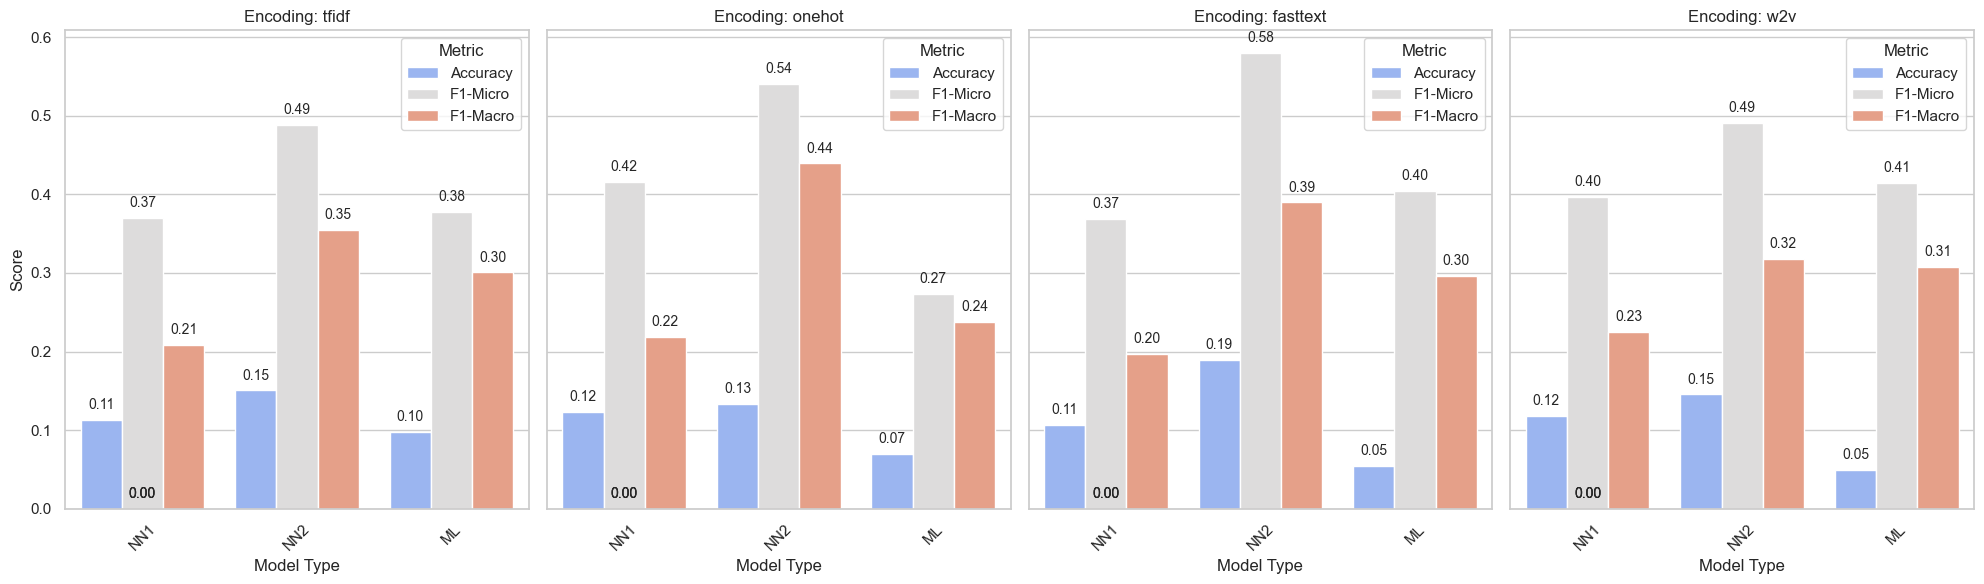

In [142]:
metrics_df = pd.DataFrame(result_metrics, index=['Accuracy', 'F1-Micro', 'F1-Macro']).T
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'Model'}, inplace=True)

metrics_df['Algorithm'] = metrics_df['Model'].apply(lambda x: x.split('_')[0])
metrics_df['Encoding'] = metrics_df['Model'].apply(lambda x: x.split('_')[1])

sns.set(style='whitegrid', palette='muted')

melted_df = pd.melt(metrics_df, id_vars=['Model', 'Algorithm', 'Encoding'], 
                    value_vars=['Accuracy', 'F1-Micro', 'F1-Macro'], 
                    var_name='Metric', value_name='Score')

fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

encodings = ['tfidf', 'onehot', 'fasttext', 'w2v']

for i, encoding in enumerate(encodings):
    encoding_data = melted_df[melted_df['Encoding'] == encoding]
    
    ax = sns.barplot(x='Algorithm', y='Score', hue='Metric', data=encoding_data, 
                     ax=axes[i], palette='coolwarm', errorbar=None)
    
    axes[i].set_title(f'Encoding: {encoding}')
    axes[i].set_xlabel('Model Type')
    plt.setp(axes[i].get_xticklabels(), rotation=45)
    axes[i].set_ylabel('Score' if i == 0 else '')

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.01, 
                f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


Лучшие результаты были показаны моделью NN2 (с LSTM). ML оказался лучше простой модели NN1 для всех типов эмбеддингов. Вторая модель лучше первой, потому что включает LSTM для временных зависимостей, Dropout для предотвращения переобучения, Batch Normalization для ускорения обучения и дополнительный линейный слой для улучшения представлений. Эти улучшения делают модель более устойчивой и точной для последовательных данных.
Fasttext для этих данных показал лучшие результаты в сравнении с другими эмбеддингами.